## Download Car License Plate Detection Dataset from Kaggle
Source: https://www.kaggle.com/general/74235

1. Go to your account, Scroll to **API** section and **Click Expire API Token** to remove previous tokens

2. Click on **Create New API Token** - It will download kaggle.json file on your machine.

3. Go to your Google Colab project file and run the following commands:

1) <code>! pip install -q kaggle</code>

2) upload kaggle.json to your colab folder

3) <code>! mkdir ~/.kaggle</code>

  <code>! cp kaggle.json ~/.kaggle/</code>

4) <code>! chmod 600 ~/.kaggle/kaggle.json</code>

Change the permissions of the file.

**Download Data**

<code>! kaggle competitions download -c 'name-of-competition'</code>

In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d andrewmvd/car-plate-detection

In [ ]:
!unzip car-plate-detection.zip

## Take a look a sample image

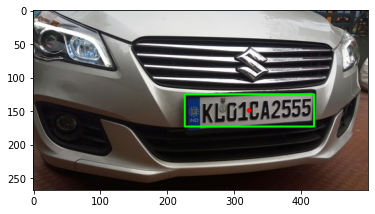

In [3]:
import cv2 as cv
import matplotlib.pyplot as plt

img = cv.imread('/content/images/Cars0.png')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

rec = cv.rectangle(img, (226,125), (419,173), (0,250,0),2)
rec = cv.circle(rec, ((226+419)//2,(125+173)//2), 2, (255,0,0),2)
plt.imshow(rec)

## Create Dataset
1. dataset.yaml

```python
#Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]

path: ../datasets/coco128  # dataset root dir  
train: images/train2017  # train images (relative to 'path') 128 images   
val: images/train2017  # val images (relative to 'path') 128 images  
test:  # test images (optional)
#Classes

names:  
  0: person  
  1: bicycle  
  2: car  
  ...
```

2. label.txt  
one *.txt file per image (if no objects in image, no *.txt file is required). The *.txt file specifications are:

- One row per object
- Each row is <code>class x_center y_center width height</code> format.
- Box coordinates must be in normalized xywh format (from 0 - 1). If your boxes are in pixels, divide x_center and width by image width, and y_center and height by image height.
- Class numbers are zero-indexed (start from 0)

<img src="https://user-images.githubusercontent.com/26833433/112467037-d2568c00-8d66-11eb-8796-55402ac0d62f.png" alt= "label example" width=400 height=200>

3. Directories organization

<img src="https://user-images.githubusercontent.com/26833433/134436012-65111ad1-9541-4853-81a6-f19a3468b75f.png" alt= "directories example" width=600 height=500>

In [ ]:
def normalized_coordinates(filename, width, height, xmin, ymin, xmax, ymax):
  xmin, xmax = xmin / width, xmax / width
  ymin, ymax = ymin / height, ymax/ height

  width = xmax-xmin
  height = ymax-ymin
  x_center = xmin + (width / 2)
  y_center = ymin + (height / 2)

  return x_center, y_center, width, height

def write_label(filename, x_center, y_center, width, height):
  with open(filename, mode='w') as outf:
    outf.write(f"{1} {x_center} {y_center} {width} {height}\n")

def parse_xml_tags(data):
  tags = ['filename', 'width', 'height', 'xmin', 'ymin', 'xmax', 'ymax']
  Bs_data = BeautifulSoup(data, "xml")
  d = dict()

  for t in tags:
    text = Bs_data.find(t).text
    if all(c.isdigit() for c in text):
      d[t] = int(text)
    else:
      d[t] = text
  
  return d

from pathlib import Path
import shutil

def build_data(dataset, mode):
  img_dir = Path(f"/content/plate_data/{mode}/images")
  img_dir.mkdir(parents=True, exist_ok=True)

  label_dir = Path(f"/content/plate_data/{mode}/labels")
  label_dir.mkdir(parents=True, exist_ok=True)

  for file in dataset:
    with open(f"/content/annotations/{file}", 'r') as f:
      data = f.read()
    d = parse_xml_tags(data)

    shutil.copy(f"/content/images/{d['filename']}", f"{img_dir}/{d['filename']}")

    x_center, y_center, width, height = normalized_coordinates(**d)
    write_label(f"{label_dir}/{d['filename'][:-4]}.txt", x_center, y_center, width, height)

In [ ]:
from bs4 import BeautifulSoup
import os
from sklearn.model_selection import train_test_split

train, val = train_test_split(os.listdir("/content/annotations"), test_size=0.1)

build_data(val, 'val')
build_data(train, 'train')

In [ ]:
# path: /content/plate_data  # dataset root dir
# train: /content/plate_data/train/images  # train images (relative to 'path')
# val: /content/plate_data/val/images  # val images (relative to 'path')
# test:  # test images (optional)

# names:
#   0: no_car_plate
#   1: car_lisence_plate
#   2: car

## Install requirements

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
!pip install -r requirements.txt  # install

In [ ]:
!python train.py --img 416 --batch 16 --epochs 8 --data /content/dataset.yaml --weights yolov5s.pt --cache ram

In [ ]:
# from google.colab import files
# files.download('/content/yolov5/runs/train/exp/weights/best.pt')

## Load model

In [ ]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/yolov5/runs/train/exp/weights/best.pt')

## Inference

In [ ]:
%cd /content
!cp /content/plate_data/val/images/Cars343.png .
im = '/content/Cars343.png'

# Inference
results = model(im)

cordinates = results.xyxy[0][:, :-1]
results.pandas().xyxy[0]

## Grab car plate number

In [ ]:
!pip install easyocr

In [ ]:
def read_plate_number(results, frame, reader):
  n = len(results)
  x_shape, y_shape = frame.shape[1], frame.shape[0]

  for i in range(n):
    row = cordinates[i] # Iterate through each image
    if row[4] >= 0.2: ## Take img with 0.5 confidence
      xmin, ymin, xmax, ymax = row[:4]
      plate = frame[int(ymin):int(ymax), int(xmin):int(xmax)]

      ## Preprocess Plate
      gray = cv.cvtColor(plate, cv.COLOR_BGR2GRAY)
      blurred = cv.bilateralFilter(gray, 17, 15, 15)
      ret, thresh = cv.threshold(blurred, 125, 255, cv.THRESH_BINARY)

      ## OCR
      text = reader.readtext(thresh)[0][-2]

      plot_img = frame.copy()

      cv.rectangle(plot_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 2) ## BBox
      cv.rectangle(plot_img, (int(xmin), int(ymin-20)), (int(xmax), int(ymin)), (0, 255,0), -1) ## for text label background
      final_img = cv.putText(plot_img, f"{text}", (int(xmin), int(ymin)), cv.FONT_HERSHEY_SIMPLEX, 0.5,(255,255,255), 2)

      cv.imwrite(f'labeled_img_{i}.jpg', cv.cvtColor(final_img, cv.COLOR_BGR2RGB))

In [ ]:
%matplotlib inline
import cv2 as cv
import matplotlib.pyplot as plt
import easyocr

reader = easyocr.Reader(['en'])
cordinates = cordinates.cpu().numpy()

In [ ]:
frame = cv.imread(im) ### reading the image
frame = cv.cvtColor(frame,cv.COLOR_BGR2RGB)
        
read_plate_number(cordinates, frame, reader)